# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Сверточные нейронные сети { display-mode: "both" }
# В программе используется API в TensorFlow для реализации двухслойных сверточных нейронных сетей
# coding: utf-8
import tensorflow.examples.tutorials.mnist.input_data as input_data
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [0]:
#@markdown - **Определение функций инициализации**
def glorot_init(shape, name):
    initial = tf.truncated_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))
    return tf.Variable(initial, name=name)

def bias_init(shape, name):
    initial =  tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [0]:
#@markdown - **Настройка гиперпараметров**
mnist = input_data.read_data_sets('sample_data/MNIST_data', one_hot=True)
num_epochs = 12000 #@param {type: "integer"}
batch_size = 196 #@param {type: "integer"}
learning_rate = 8e-4 #@param {type: "number"}

dir_path = 'GoogleDrive/My Drive/Colab Notebooks'
event_path = os.path.join(dir_path, 'Tensorboard')
checkpoint_path = os.path.join(dir_path, 'Checkpoints')


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting sample_data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting sample_data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting sample_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
#@markdown - **Создание graph**
graph = tf.Graph()
with graph.as_default():

    with tf.name_scope('Input'):
        x = tf.placeholder(tf.float32, shape=[None, 784], name='input_images')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        x_image = tf.reshape(x, [-1, 28, 28, 1])
        keep_prob = tf.placeholder(tf.float32)

    #@markdown - **Настройка сверточных слоев**
    # --------------conv1-----------------------------------
    with tf.name_scope('Conv1'):
        with tf.name_scope('weights_conv1'):
            W_conv1 = glorot_init([3, 3, 1, 64], 'w_conv1')
        with tf.name_scope('bias_covn1'):
            b_conv1 = bias_init([64], 'b_conv1')            
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        with tf.name_scope('features_conv1'):
            h_pool1 = max_pool_2x2(h_conv1)

    # --------------conv2-----------------------------------
    with tf.name_scope('Conv2'):
        W_conv2 = glorot_init([3, 3, 64, 128], 'w_conv2')
        b_conv2 = bias_init([128], 'b_conv2')
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
        
    #@markdown - **Настройка полносвязных слоев**
    # --------------fc--------------------------------------
    h_pool2_flat = tf.layers.flatten(h_pool2)
    num_f = h_pool2_flat.get_shape().as_list()[-1]
    with tf.name_scope('FC1'):
        W_fc1 = glorot_init([num_f, 128], 'w_fc1')
        b_fc1 = bias_init([128], 'b_fc1')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('Dropout'):    
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        
    with tf.name_scope('FC2'):
        W_fc2 = glorot_init([128, 10], 'w_fc2')
        b_fc2 = bias_init([10], 'b_fc2')
        y_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    with tf.name_scope('Loss'):
        y_out = tf.nn.softmax(y_fc2)
#         cross_entropy = -tf.reduce_mean(y_*tf.log(y_out + 1e-10))
        # # or like
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,
                                                                            logits=y_fc2))
    with tf.name_scope('Train'):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
        # # or like
        # optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)
        # grad_list = optimizer.compute_gradients(cross_entropy)
        # train_step = optimizer.apply_gradients(grad_list)

    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_out, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#@markdown - **Обучение сетей и сохранение моделей**
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=3) # сохранить 3 модели
    max_acc = 101. # модели с более высокой точностью будут сохранены

    for epoch in range(num_epochs):
        batch = mnist.train.next_batch(batch_size)
        _, acc, loss = sess.run([train_step, accuracy, cross_entropy], feed_dict={x: batch[0], 
                                                                                y_: batch[1], 
                                                                                keep_prob: 0.5})
        step = epoch + 1
        if step % 1000 == 0:
            acc *= 100
            print_list = [step, loss, acc]
            print("Epoch: {0[0]}, cross_entropy: {0[1]:.4f}, accuracy on training data: {0[2]:.2f}%,".format(print_list))
            test_acc, test_loss = sess.run([accuracy, cross_entropy], feed_dict={x: mnist.test.images, 
                                                                                y_: mnist.test.labels, 
                                                                                keep_prob: 1.0})
            test_acc *= 100
            print_list = [test_loss, test_acc]
            print(' '*12, 'cross_entropy: {0[0]:.4f}, accuracy on testing data: {0[1]:.2f}%.'.format(print_list))
            print('\n')
        
        if (acc > max_acc) & (step > 3999):
            max_acc = acc
            saver.save(sess, os.path.join(checkpoint_path, 'f_map.ckpt'), global_step=step)

    test_image, test_label = mnist.test.images[100, :].reshape((1, -1)), mnist.test.labels[100, :].reshape((1, -1))
    features1, features2 = sess.run([h_pool1, h_pool2], feed_dict={x: test_image, y_: test_label, keep_prob: 1.0})

Epoch: 1000, cross_entropy: 0.6997, accuracy on training data: 72.45%,
             cross_entropy: 0.1718, accuracy on testing data: 96.03%.


Epoch: 2000, cross_entropy: 0.4519, accuracy on training data: 82.14%,
             cross_entropy: 0.0626, accuracy on testing data: 98.28%.


Epoch: 3000, cross_entropy: 0.2301, accuracy on training data: 92.35%,
             cross_entropy: 0.0548, accuracy on testing data: 98.38%.


Epoch: 4000, cross_entropy: 0.1407, accuracy on training data: 95.41%,
             cross_entropy: 0.0475, accuracy on testing data: 98.66%.


Epoch: 5000, cross_entropy: 0.1878, accuracy on training data: 92.86%,
             cross_entropy: 0.0448, accuracy on testing data: 98.80%.


Epoch: 6000, cross_entropy: 0.1025, accuracy on training data: 95.92%,
             cross_entropy: 0.0386, accuracy on testing data: 98.97%.


Epoch: 7000, cross_entropy: 0.0510, accuracy on training data: 98.47%,
             cross_entropy: 0.0383, accuracy on testing data: 98.98%.



In [0]:
#@markdown - **Восстановление сохраненной модели**
# with tf.Session() as sess:
    # model_path = 'GoogleDrive/My Drive/Colab Notebooks/Tensorboard/f_map.ckpt-241'
    # saver.restore(sess, model_path)
    # acc, loss = sess.run([accuracy, cross_entropy], feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
    # print('Accuracy is %.2f.' %(acc))
# sess.close()

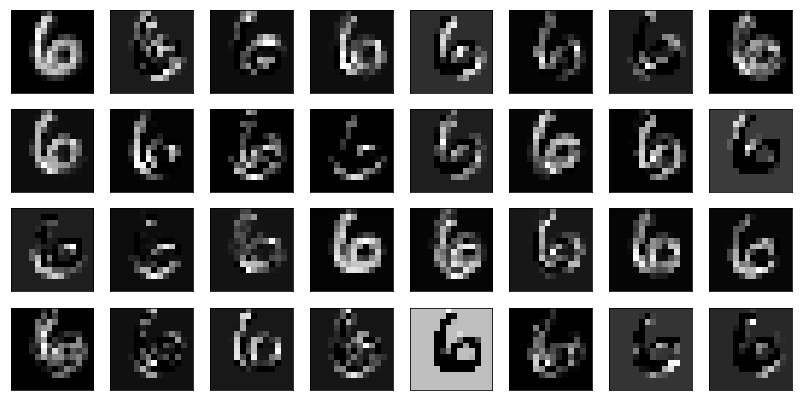

In [0]:
#@markdown - **Представление feature map первого сверточного слоя**
features_map = features1.reshape((14, 14, 64))
num_map = range(features_map.shape[-1])
fig, AX = plt.subplots(nrows=4, ncols=8)
fig.set_size_inches(w=14, h=7)
fig.subplots_adjust(wspace=.2, hspace=.2)
try:
    for index, ax in enumerate(AX.flatten()):
        ax.imshow(features_map[:, :, index], 'gray')
        ax.set_xticks([]), ax.set_yticks([])
except IndexError:
    pass
plt.show()

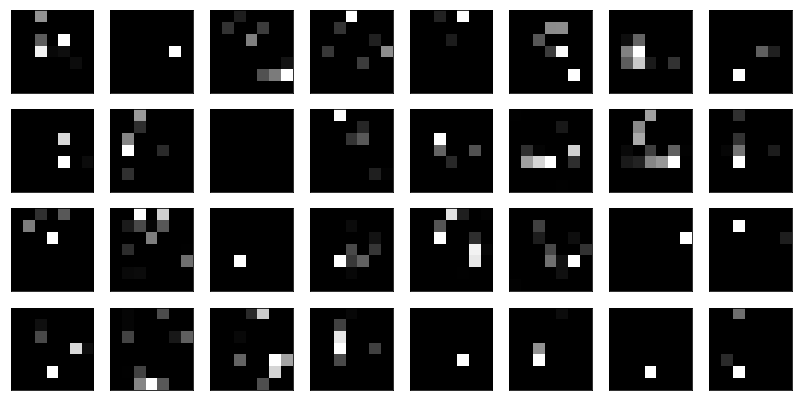

In [0]:
#@markdown - **Представление feature map второго сверточного слоя**
features_map = features2.reshape((7, 7, 128))
num_map = range(features_map.shape[-1])
fig, AX = plt.subplots(nrows=4, ncols=8)
fig.set_size_inches(w=14, h=7)
fig.subplots_adjust(wspace=.2, hspace=.2)
try:
    for index, ax in enumerate(AX.flatten()):
        ax.imshow(features_map[:, :, index], 'gray')
        ax.set_xticks([]), ax.set_yticks([])
except IndexError:
    pass
plt.show()